# ARIMA Model for Time Series Forecasting

This notebook demonstrates the ARIMA (AutoRegressive Integrated Moving Average) model for stock price forecasting.

**Contents:**
1. **Stationarity Analysis** - ADF and KPSS tests
2. **Auto-Parameter Selection** - Finding optimal (p, d, q)
3. **Model Fitting** - Training the ARIMA model
4. **Evaluation** - Performance metrics (MAE, RMSE, MAPE)
5. **Forecasting** - Future predictions with confidence intervals
6. **Model Diagnostics** - Residual analysis

ARIMA combines three components:
- **AR (p)**: Autoregressive - uses past values to predict future
- **I (d)**: Integrated - differencing to achieve stationarity
- **MA (q)**: Moving Average - uses past forecast errors

## Setup

In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
sys.path.insert(0, os.path.dirname(os.getcwd()))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Project modules
import config
from src.data_cleaning import cleaned_data_loader
from src.models.baseline import train_test_split
from src.models.arima_model import (
    ARIMAModel,
    check_stationarity,
    auto_arima,
    evaluate_arima,
    forecast_future_arima,
    run_arima_analysis,
    find_optimal_d
)

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

print("Configuration:")
print(f"  Train/Test Split: {config.TRAIN_TEST_SPLIT}")
print(f"  Prediction Horizon: {config.PREDICTION_HORIZON_DAYS} days")
print(f"  Default ARIMA Order: {config.ARIMA_ORDER}")
print(f"  Use Auto-ARIMA: {config.USE_AUTO_ARIMA}")

Configuration:
  Train/Test Split: 0.8
  Prediction Horizon: 20 days
  Default ARIMA Order: (5, 1, 0)
  Use Auto-ARIMA: True


## Load Data

In [2]:
# Load cleaned data
data = cleaned_data_loader()

print(f"\nData shape: {data.shape}")
print(f"Date range: {data.index.min()} to {data.index.max()}")
data.tail()

Loading cleaned data from: data/processed\cleaned_data_20260120_010244.csv
Loaded 1519 data points
Date range: 2020-01-02 00:00:00 to 2026-01-16 00:00:00
Columns: Open, High, Low, Close, Volume

Data shape: (1519, 5)
Date range: 2020-01-02 00:00:00 to 2026-01-16 00:00:00


,Open,High,Low,Close,Volume
Date,,,,,
2026-01-12,259.160004,261.299988,256.799988,260.250000,45263800
2026-01-13,258.720001,261.809998,258.390015,261.049988,45730800
2026-01-14,259.489990,261.820007,256.709991,259.959991,40019400
2026-01-15,260.649994,261.040009,257.049988,258.209991,39388600
2026-01-16,257.899994,258.899994,254.929993,255.529999,72018600


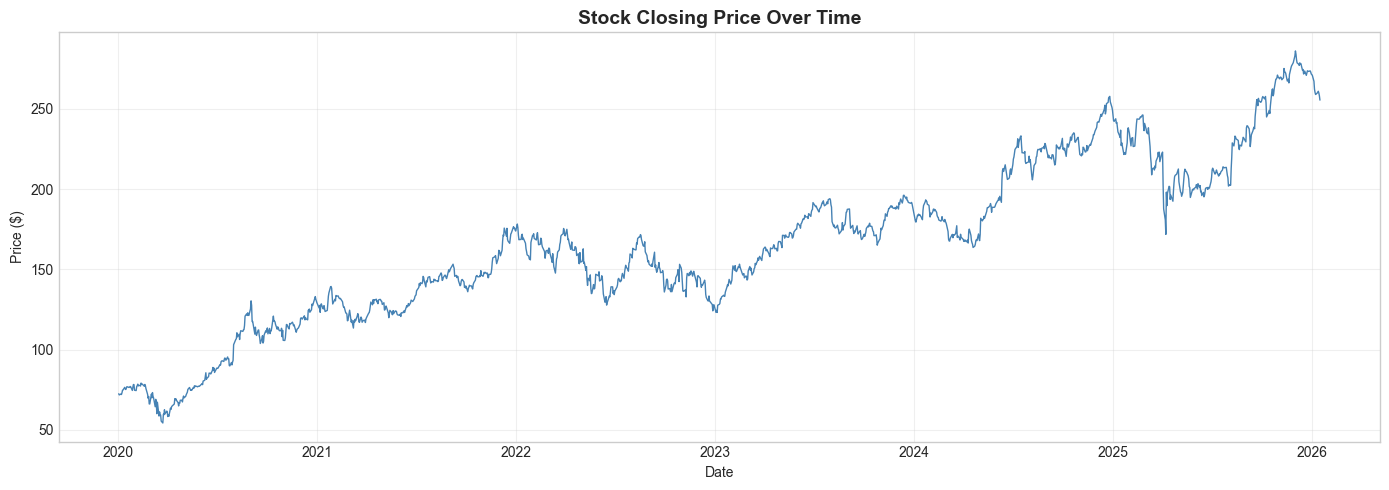

In [3]:
# Plot the time series
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(data.index, data['Close'], color='steelblue', linewidth=1)
ax.set_title('Stock Closing Price Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Train/Test Split

Time-based split (no shuffling) to maintain temporal order.

In [4]:
# Split data
train, test = train_test_split(data, train_ratio=config.TRAIN_TEST_SPLIT)

print(f"\nTrain set: {len(train)} samples")
print(f"Test set: {len(test)} samples")

Train/Test Split:
  Train: 1215 samples (2020-01-02 to 2024-10-29)
  Test: 304 samples (2024-10-30 to 2026-01-16)

Train set: 1215 samples
Test set: 304 samples


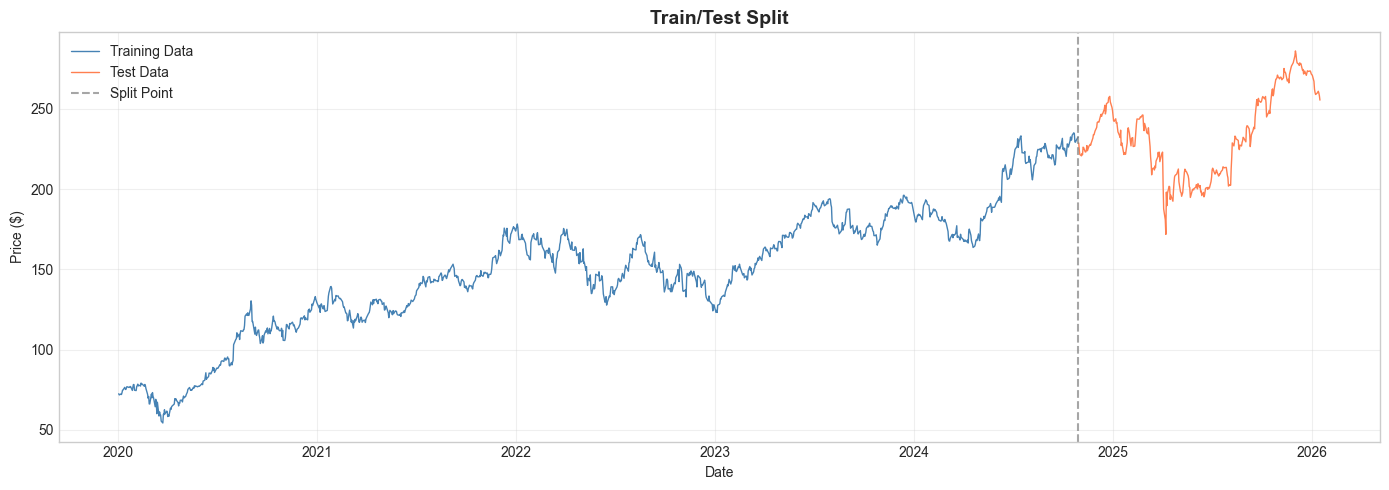

In [5]:
# Visualize train/test split
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train.index, train['Close'], color='steelblue', label='Training Data', linewidth=1)
ax.plot(test.index, test['Close'], color='coral', label='Test Data', linewidth=1)
ax.axvline(x=train.index[-1], color='gray', linestyle='--', alpha=0.7, label='Split Point')
ax.set_title('Train/Test Split', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 1. Stationarity Analysis

ARIMA requires stationary data. We use two statistical tests:
- **ADF Test (Augmented Dickey-Fuller)**: Tests for unit root (H0: non-stationary)
- **KPSS Test**: Tests for stationarity (H0: stationary)

| ADF | KPSS | Conclusion |
|-----|------|------------|
| Reject H0 | Fail to reject H0 | Stationary |
| Fail to reject H0 | Reject H0 | Non-stationary |
| Reject H0 | Reject H0 | Trend-stationary |
| Fail to reject H0 | Fail to reject H0 | Difference-stationary |

In [6]:
# Check stationarity of original series
print("=" * 60)
print("ORIGINAL SERIES")
print("=" * 60)
stationarity_original = check_stationarity(train['Close'], verbose=True)

ORIGINAL SERIES

--- Stationarity Tests ---
ADF Test:
  Statistic: -1.0129
  p-value: 0.7485
  Is Stationary: False
KPSS Test:
  Statistic: 4.7310
  p-value: 0.0100
  Is Stationary: False
Conclusion: Non-stationary
Recommended d (differencing): 1


In [7]:
# Check stationarity after first differencing
print("\n" + "=" * 60)
print("FIRST DIFFERENCE (d=1)")
print("=" * 60)
diff1 = train['Close'].diff().dropna()
stationarity_diff1 = check_stationarity(diff1, verbose=True)


FIRST DIFFERENCE (d=1)

--- Stationarity Tests ---
ADF Test:
  Statistic: -35.5110
  p-value: 0.0000
  Is Stationary: True
KPSS Test:
  Statistic: 0.0496
  p-value: 0.1000
  Is Stationary: True
Conclusion: Stationary
Recommended d (differencing): 0


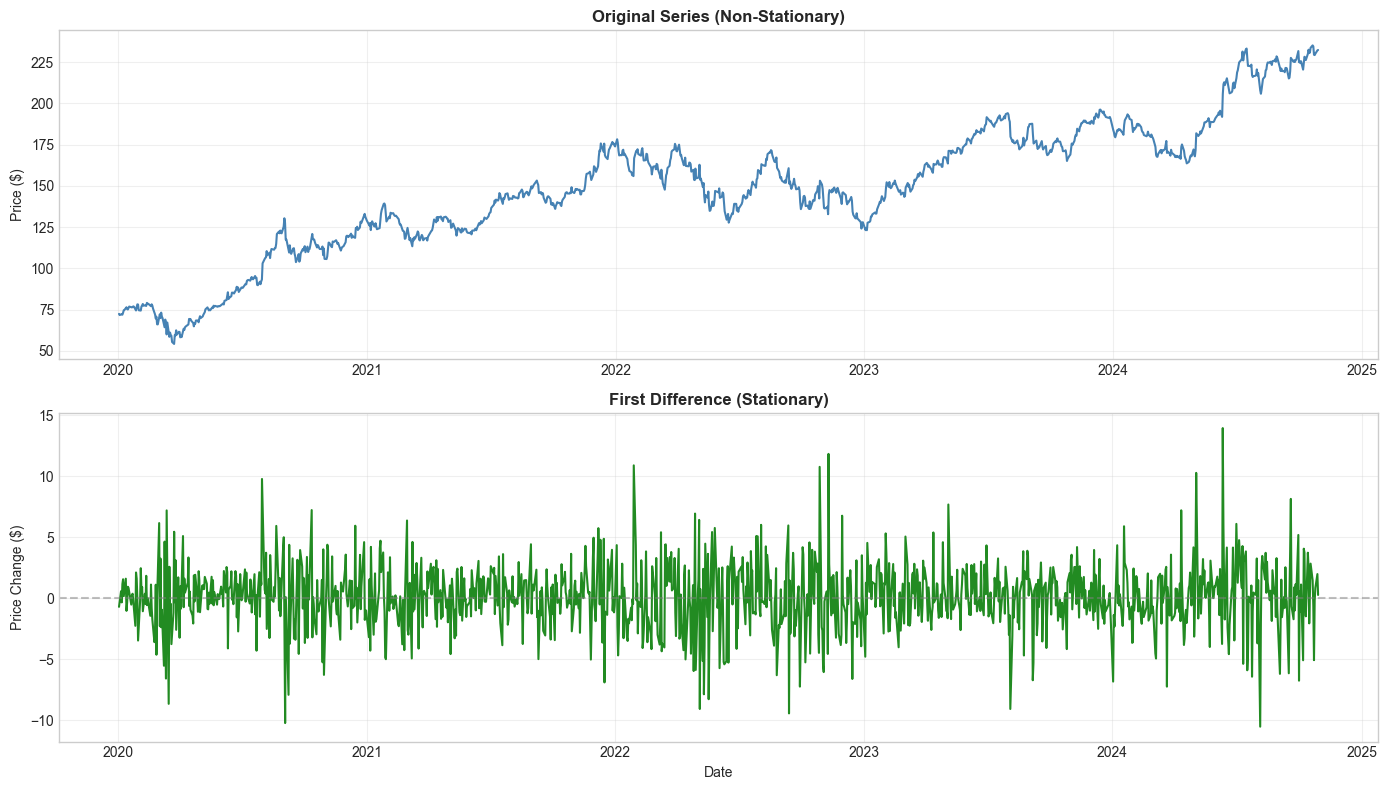

In [8]:
# Visualize original vs differenced series
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Original series
axes[0].plot(train.index, train['Close'], color='steelblue')
axes[0].set_title('Original Series (Non-Stationary)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].grid(True, alpha=0.3)

# First difference
axes[1].plot(diff1.index, diff1.values, color='forestgreen')
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1].set_title('First Difference (Stationary)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Price Change ($)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. ACF and PACF Analysis

ACF and PACF plots help determine the order of AR (p) and MA (q) components:
- **PACF** (Partial Autocorrelation): Suggests AR order (p) - significant lags before cutoff
- **ACF** (Autocorrelation): Suggests MA order (q) - significant lags before cutoff

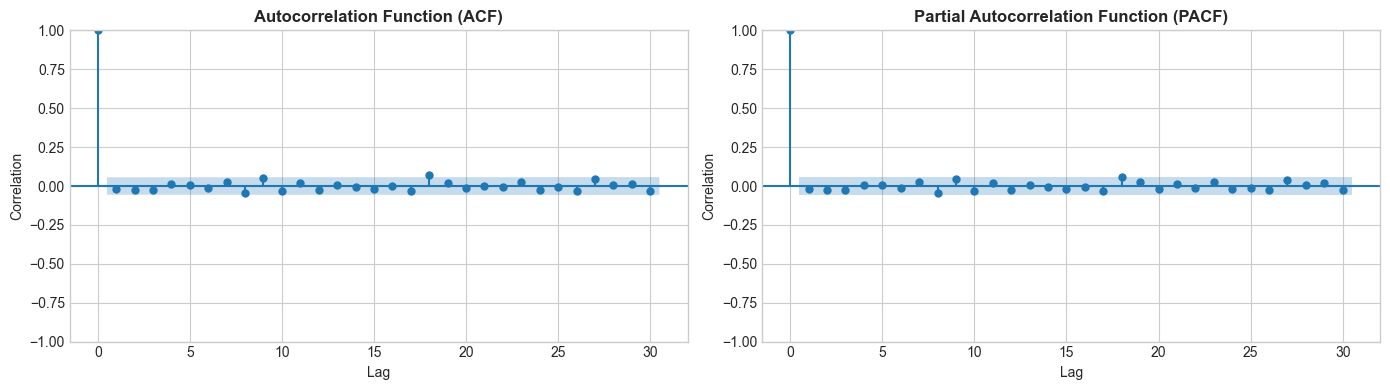

Interpretation:
- PACF shows significant lags suggesting AR order (p)
- ACF shows significant lags suggesting MA order (q)
- Both cut off quickly, suggesting low order may be sufficient


In [9]:
# ACF and PACF plots for differenced series
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# ACF
plot_acf(diff1, lags=30, ax=axes[0], alpha=0.05)
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Correlation')

# PACF
plot_pacf(diff1, lags=30, ax=axes[1], alpha=0.05, method='ywm')
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Correlation')

plt.tight_layout()
plt.show()

print("Interpretation:")
print("- PACF shows significant lags suggesting AR order (p)")
print("- ACF shows significant lags suggesting MA order (q)")
print("- Both cut off quickly, suggesting low order may be sufficient")

## 3. Auto-ARIMA Parameter Selection

Automatically find optimal (p, d, q) parameters using information criteria (AIC/BIC).

In [10]:
# Run auto-ARIMA to find optimal parameters
auto_result = auto_arima(
    train['Close'],
    max_p=5,
    max_d=2,
    max_q=5,
    criterion='aic',
    stepwise=True,
    verbose=True
)

print(f"\nOptimal Order: {auto_result['order']}")
print(f"AIC: {auto_result['criterion_value']:.2f}")


AUTO-ARIMA PARAMETER SELECTION

Step 1: Optimal differencing d = 1

Step 2: Optimal (p, q) = (0, 1)
Best AIC: 5826.02

Optimal ARIMA order: (0, 1, 1)

Optimal Order: (0, 1, 1)
AIC: 5826.02


## 4. Model Fitting

Fit the ARIMA model with the selected parameters.

In [11]:
# Create and fit ARIMA model with auto-selected parameters
model_auto = ARIMAModel(use_auto=True, max_p=5, max_q=5)
model_auto.fit(train, column='Close')

print(f"\nFitted Model: {model_auto.name}")


--- Fitting ARIMA Model ---
Training samples: 1215
Date range: 2020-01-02 to 2024-10-29

AUTO-ARIMA PARAMETER SELECTION

Step 1: Optimal differencing d = 1

Step 2: Optimal (p, q) = (0, 1)
Best AIC: 5826.02

Optimal ARIMA order: (0, 1, 1)

Fitting ARIMA(0, 1, 1)...
Model fitted successfully!
AIC: 5826.02
BIC: 5836.22

Fitted Model: ARIMA(0, 1, 1)


In [12]:
# Display model summary
print(model_auto.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1215
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2911.009
Date:                Tue, 20 Jan 2026   AIC                           5826.018
Time:                        15:51:42   BIC                           5836.221
Sample:                             0   HQIC                          5829.859
                               - 1215                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0186      0.024     -0.761      0.446      -0.066       0.029
sigma2         7.0842      0.206     34.443      0.000       6.681       7.487
Ljung-Box (L1) (Q):                   0.01   Jarque-

In [13]:
# Also fit a simple ARIMA(1,1,1) for comparison
model_simple = ARIMAModel(order=(1, 1, 1), use_auto=False)
model_simple.fit(train, column='Close')

print(f"\nSimple Model: {model_simple.name}")
print(f"AIC: {model_simple.fitted_model.aic:.2f}")
print(f"BIC: {model_simple.fitted_model.bic:.2f}")


--- Fitting ARIMA Model ---
Training samples: 1215
Date range: 2020-01-02 to 2024-10-29

Fitting ARIMA(1, 1, 1)...
Model fitted successfully!
AIC: 5827.32
BIC: 5842.63

Simple Model: ARIMA(1, 1, 1)
AIC: 5827.32
BIC: 5842.63


## 5. Model Evaluation

Evaluate model performance on the test set using MAE, RMSE, and MAPE.

In [14]:
# Evaluate auto-selected model
print("=" * 60)
print("AUTO-ARIMA MODEL EVALUATION")
print("=" * 60)
eval_auto = evaluate_arima(model_auto, test, column='Close')

AUTO-ARIMA MODEL EVALUATION

ARIMA(0, 1, 1) Evaluation:
  MAE: $21.08
  RMSE: $25.19
  MAPE: 9.08%
  AIC: 5826.02
  BIC: 5836.22


In [15]:
# Evaluate simple ARIMA(1,1,1)
print("\n" + "=" * 60)
print("SIMPLE ARIMA(1,1,1) EVALUATION")
print("=" * 60)
eval_simple = evaluate_arima(model_simple, test, column='Close')


SIMPLE ARIMA(1,1,1) EVALUATION

ARIMA(1, 1, 1) Evaluation:
  MAE: $21.07
  RMSE: $25.20
  MAPE: 9.07%
  AIC: 5827.32
  BIC: 5842.63


In [16]:
# Compare models
comparison = pd.DataFrame({
    'Model': [model_auto.name, model_simple.name],
    'MAE ($)': [eval_auto['mae'], eval_simple['mae']],
    'RMSE ($)': [eval_auto['rmse'], eval_simple['rmse']],
    'MAPE (%)': [eval_auto['mape'], eval_simple['mape']],
    'AIC': [eval_auto['aic'], eval_simple['aic']],
    'BIC': [eval_auto['bic'], eval_simple['bic']]
})

print("\n" + "=" * 60)
print("MODEL COMPARISON")
print("=" * 60)
print(comparison.to_string(index=False))

# Identify best model
best_idx = comparison['MAE ($)'].idxmin()
print(f"\nBest Model (by MAE): {comparison.loc[best_idx, 'Model']}")


MODEL COMPARISON
         Model   MAE ($)  RMSE ($)  MAPE (%)         AIC        BIC
ARIMA(0, 1, 1) 21.075007 25.192066  9.076035 5826.017738 5836.22109
ARIMA(1, 1, 1) 21.073941 25.195321  9.073160 5827.324582 5842.62961

Best Model (by MAE): ARIMA(1, 1, 1)


In [17]:
# Use the better performing model for visualization
if eval_auto['mae'] <= eval_simple['mae']:
    best_model = model_auto
    best_eval = eval_auto
else:
    best_model = model_simple
    best_eval = eval_simple

print(f"Using: {best_model.name}")

Using: ARIMA(1, 1, 1)


## 6. Visualization: Actual vs Predicted

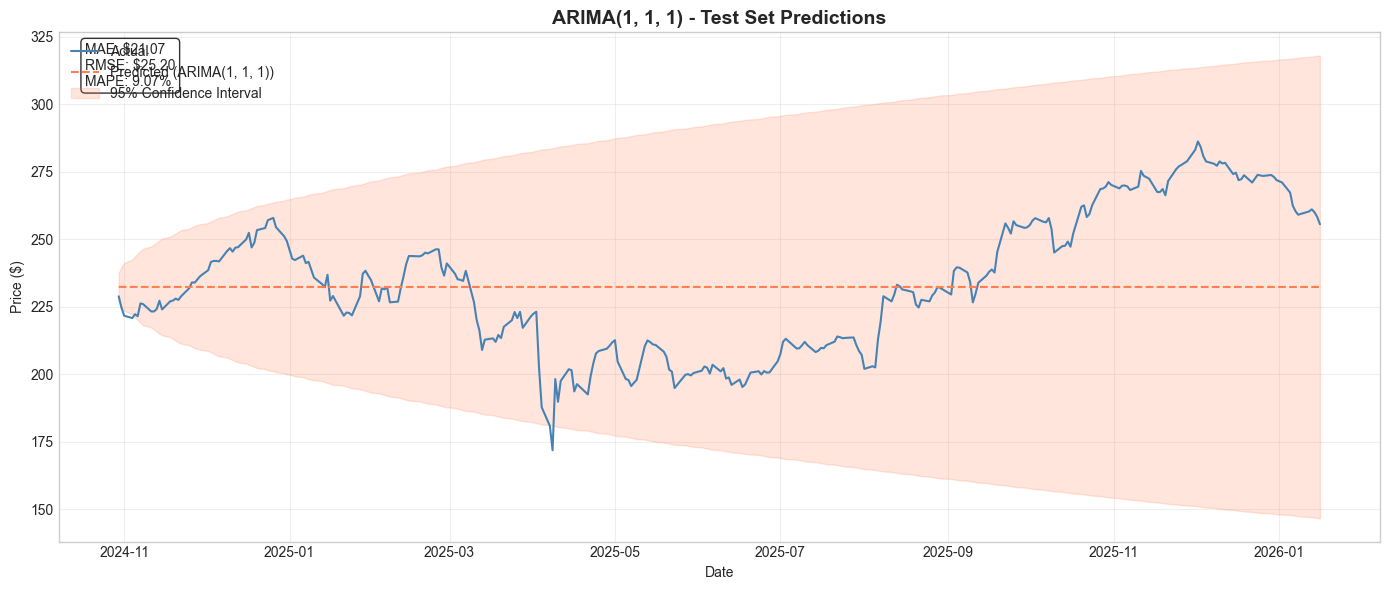

In [18]:
# Plot actual vs predicted on test set
fig, ax = plt.subplots(figsize=(14, 6))

# Actual values
ax.plot(test.index, test['Close'], color='steelblue', label='Actual', linewidth=1.5)

# Predictions
ax.plot(test.index, best_eval['predictions'], color='coral', 
        label=f'Predicted ({best_model.name})', linewidth=1.5, linestyle='--')

# Confidence intervals
ax.fill_between(test.index, best_eval['lower_bound'], best_eval['upper_bound'],
                color='coral', alpha=0.2, label='95% Confidence Interval')

ax.set_title(f'{best_model.name} - Test Set Predictions', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# Add metrics annotation
metrics_text = f'MAE: ${best_eval["mae"]:.2f}\nRMSE: ${best_eval["rmse"]:.2f}\nMAPE: {best_eval["mape"]:.2f}%'
ax.annotate(metrics_text, xy=(0.02, 0.98), xycoords='axes fraction',
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

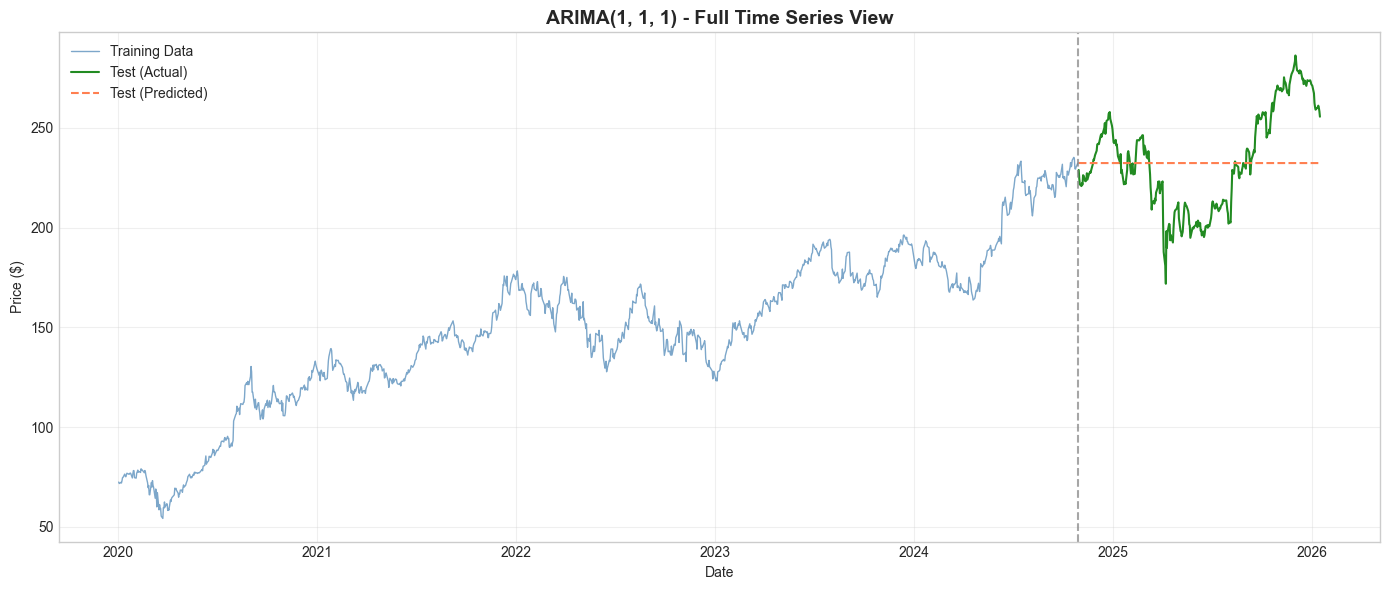

In [19]:
# Full view: Training + Test + Predictions
fig, ax = plt.subplots(figsize=(14, 6))

# Training data
ax.plot(train.index, train['Close'], color='steelblue', label='Training Data', linewidth=1, alpha=0.7)

# Test actual
ax.plot(test.index, test['Close'], color='forestgreen', label='Test (Actual)', linewidth=1.5)

# Test predictions
ax.plot(test.index, best_eval['predictions'], color='coral', 
        label=f'Test (Predicted)', linewidth=1.5, linestyle='--')

# Split line
ax.axvline(x=train.index[-1], color='gray', linestyle='--', alpha=0.7)

ax.set_title(f'{best_model.name} - Full Time Series View', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Error Analysis

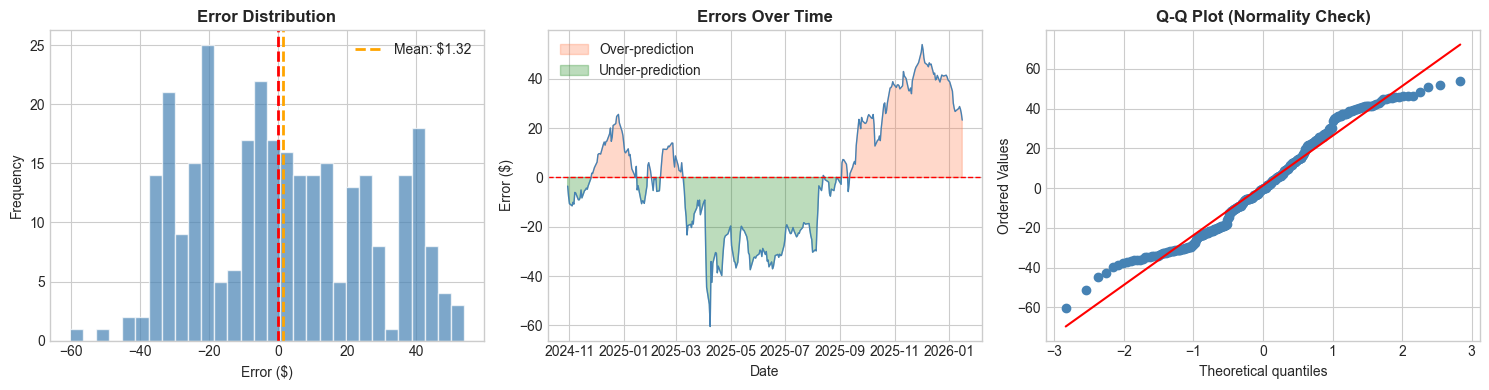

Error Statistics:
  Mean: $1.32
  Std: $25.16
  Min: $-60.46
  Max: $53.90


In [20]:
# Error distribution
errors = best_eval['errors']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram of errors
axes[0].hist(errors, bins=30, color='steelblue', edgecolor='white', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].axvline(x=np.mean(errors), color='orange', linestyle='--', linewidth=2, label=f'Mean: ${np.mean(errors):.2f}')
axes[0].set_title('Error Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Error ($)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Errors over time
axes[1].plot(test.index, errors, color='steelblue', linewidth=1)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[1].fill_between(test.index, 0, errors, where=(errors > 0), color='coral', alpha=0.3, label='Over-prediction')
axes[1].fill_between(test.index, 0, errors, where=(errors < 0), color='forestgreen', alpha=0.3, label='Under-prediction')
axes[1].set_title('Errors Over Time', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Error ($)')
axes[1].legend()

# QQ plot
from scipy import stats
stats.probplot(errors, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot (Normality Check)', fontsize=12, fontweight='bold')
axes[2].get_lines()[0].set_markerfacecolor('steelblue')
axes[2].get_lines()[0].set_markeredgecolor('steelblue')

plt.tight_layout()
plt.show()

print(f"Error Statistics:")
print(f"  Mean: ${np.mean(errors):.2f}")
print(f"  Std: ${np.std(errors):.2f}")
print(f"  Min: ${np.min(errors):.2f}")
print(f"  Max: ${np.max(errors):.2f}")

## 8. Model Diagnostics

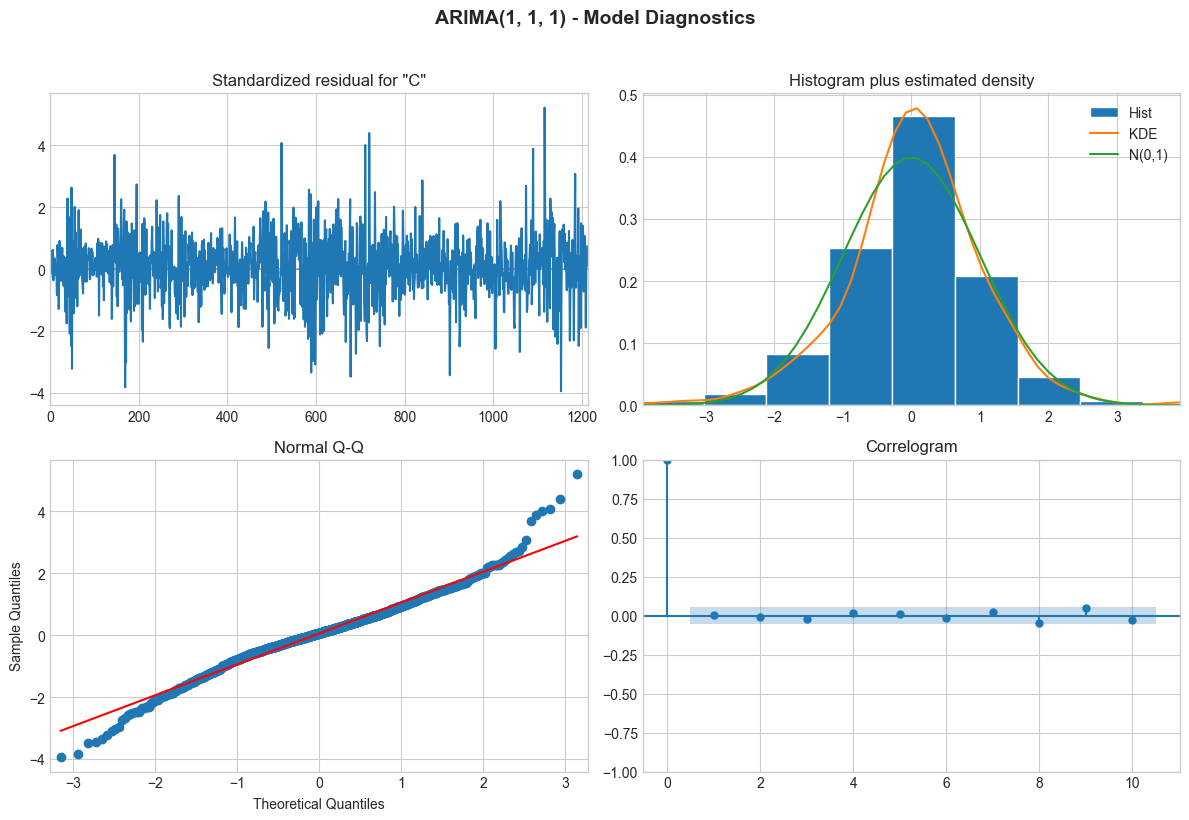

In [21]:
# Model diagnostics plot
fig = best_model.plot_diagnostics(figsize=(12, 8))
plt.suptitle(f'{best_model.name} - Model Diagnostics', y=1.02, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [22]:
# Model diagnostics summary
diagnostics = best_model.get_diagnostics()

print("=" * 60)
print("MODEL DIAGNOSTICS")
print("=" * 60)
print(f"Order: {diagnostics['order']}")
print(f"Observations: {diagnostics['n_obs']}")
print(f"\nInformation Criteria:")
print(f"  AIC: {diagnostics['aic']:.2f}")
print(f"  BIC: {diagnostics['bic']:.2f}")
print(f"  Log-Likelihood: {diagnostics['log_likelihood']:.2f}")
print(f"\nResidual Statistics:")
print(f"  Mean: {diagnostics['residual_mean']:.4f}")
print(f"  Std: {diagnostics['residual_std']:.4f}")

if 'ar_coefficients' in diagnostics:
    print(f"\nAR Coefficients: {[round(c, 4) for c in diagnostics['ar_coefficients']]}")
if 'ma_coefficients' in diagnostics:
    print(f"MA Coefficients: {[round(c, 4) for c in diagnostics['ma_coefficients']]}")

MODEL DIAGNOSTICS
Order: (1, 1, 1)
Observations: 1215

Information Criteria:
  AIC: 5827.32
  BIC: 5842.63
  Log-Likelihood: -2910.66

Residual Statistics:
  Mean: 0.1992
  Std: 3.3714

AR Coefficients: [0.5747]
MA Coefficients: [-0.5992]


## 9. Future Forecasting

Generate forecasts for the next 20 trading days (approximately 4 weeks).

In [23]:
# Refit model on all available data for future forecasting
model_final = ARIMAModel(order=best_model.order, use_auto=False)
model_final.fit(data, column='Close')

print(f"Final Model: {model_final.name}")
print(f"Trained on: {len(data)} data points")
print(f"Date range: {data.index.min().strftime('%Y-%m-%d')} to {data.index.max().strftime('%Y-%m-%d')}")


--- Fitting ARIMA Model ---
Training samples: 1519
Date range: 2020-01-02 to 2026-01-16

Fitting ARIMA(1, 1, 1)...
Model fitted successfully!
AIC: 7637.64
BIC: 7653.62
Final Model: ARIMA(1, 1, 1)
Trained on: 1519 data points
Date range: 2020-01-02 to 2026-01-16


In [24]:
# Generate future forecast
forecast_horizon = config.PREDICTION_HORIZON_DAYS
forecast = forecast_future_arima(
    model_final,
    horizon=forecast_horizon,
    last_date=data.index[-1],
    confidence_level=0.95
)

print(f"\nForecast for next {forecast_horizon} trading days:")
print(forecast)


ARIMA(1, 1, 1) - 20-day Forecast:
Confidence Level: 95%
              forecast       lower       upper
2026-01-19  255.454734  249.597308  261.312161
2026-01-20  255.438990  247.051951  263.826028
2026-01-21  255.435696  245.104130  265.767262
2026-01-22  255.435007  243.467681  267.402333
2026-01-23  255.434863  242.029319  268.840406
2026-01-26  255.434833  240.730967  270.138698
2026-01-27  255.434826  239.538304  271.331349
2026-01-28  255.434825  238.429081  272.440569
2026-01-29  255.434825  237.387906  273.481744
2026-01-30  255.434825  236.403607  274.466042
... (10 more rows)

Forecast for next 20 trading days:
              forecast       lower       upper
2026-01-19  255.454734  249.597308  261.312161
2026-01-20  255.438990  247.051951  263.826028
2026-01-21  255.435696  245.104130  265.767262
2026-01-22  255.435007  243.467681  267.402333
2026-01-23  255.434863  242.029319  268.840406
2026-01-26  255.434833  240.730967  270.138698
2026-01-27  255.434826  239.538304  271.33

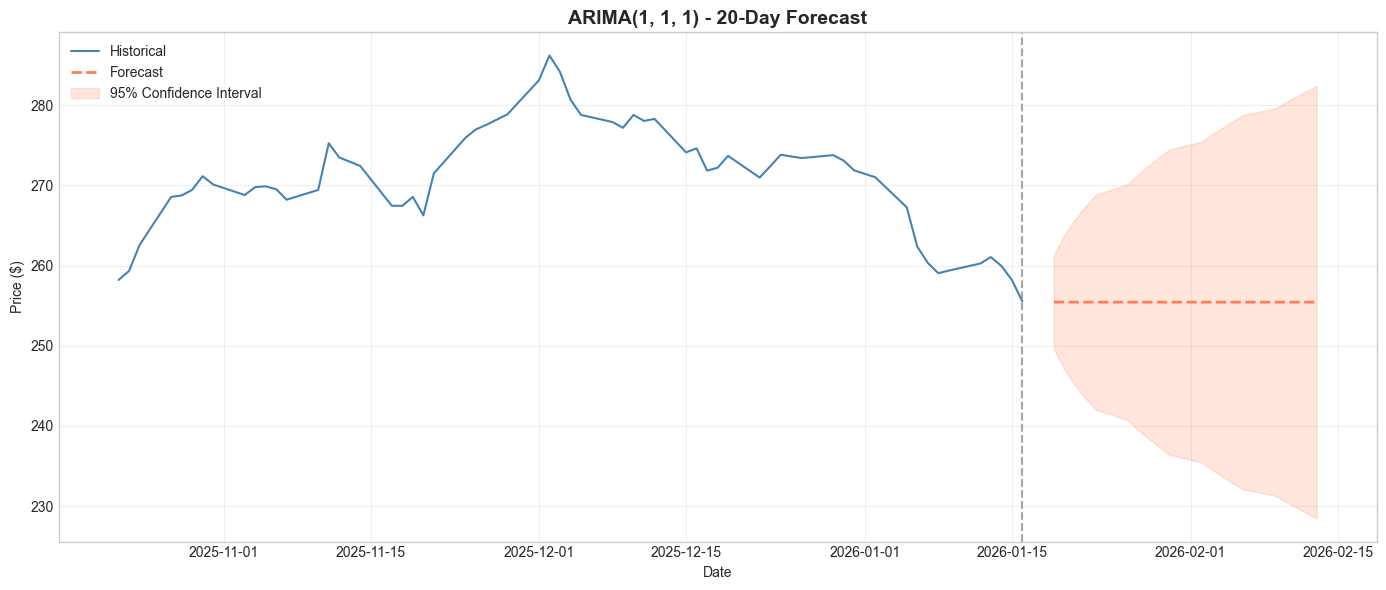


Forecast Summary:
  Last Actual Price: $255.53
  Forecast Start: $255.45
  Forecast End: $255.43
  Forecast Range: $255.43 - $255.45
  Expected Change: -0.04%


In [25]:
# Plot forecast
fig, ax = plt.subplots(figsize=(14, 6))

# Recent historical data (last 60 days)
recent_days = 60
recent_data = data.iloc[-recent_days:]

ax.plot(recent_data.index, recent_data['Close'], color='steelblue', 
        label='Historical', linewidth=1.5)

# Forecast
ax.plot(forecast.index, forecast['forecast'], color='coral', 
        label='Forecast', linewidth=2, linestyle='--')

# Confidence interval
ax.fill_between(forecast.index, forecast['lower'], forecast['upper'],
                color='coral', alpha=0.2, label='95% Confidence Interval')

# Vertical line at forecast start
ax.axvline(x=data.index[-1], color='gray', linestyle='--', alpha=0.7)

ax.set_title(f'{model_final.name} - {forecast_horizon}-Day Forecast', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nForecast Summary:")
print(f"  Last Actual Price: ${data['Close'].iloc[-1]:.2f}")
print(f"  Forecast Start: ${forecast['forecast'].iloc[0]:.2f}")
print(f"  Forecast End: ${forecast['forecast'].iloc[-1]:.2f}")
print(f"  Forecast Range: ${forecast['forecast'].min():.2f} - ${forecast['forecast'].max():.2f}")
print(f"  Expected Change: {((forecast['forecast'].iloc[-1] / data['Close'].iloc[-1]) - 1) * 100:.2f}%")

## 10. Summary

In [26]:
print("=" * 60)
print("ARIMA MODEL ANALYSIS SUMMARY")
print("=" * 60)

print(f"\n1. DATA:")
print(f"   Total samples: {len(data)}")
print(f"   Date range: {data.index.min().strftime('%Y-%m-%d')} to {data.index.max().strftime('%Y-%m-%d')}")
print(f"   Train/Test split: {config.TRAIN_TEST_SPLIT * 100:.0f}% / {(1-config.TRAIN_TEST_SPLIT) * 100:.0f}%")

print(f"\n2. STATIONARITY:")
print(f"   Original series: {stationarity_original['conclusion']}")
print(f"   After differencing: {stationarity_diff1['conclusion']}")
print(f"   Recommended d: {stationarity_original['recommended_d']}")

print(f"\n3. OPTIMAL MODEL:")
print(f"   Model: {best_model.name}")
print(f"   AIC: {best_eval['aic']:.2f}")
print(f"   BIC: {best_eval['bic']:.2f}")

print(f"\n4. TEST SET PERFORMANCE:")
print(f"   MAE: ${best_eval['mae']:.2f}")
print(f"   RMSE: ${best_eval['rmse']:.2f}")
print(f"   MAPE: {best_eval['mape']:.2f}%")

print(f"\n5. FORECAST ({forecast_horizon} days):")
print(f"   Current Price: ${data['Close'].iloc[-1]:.2f}")
print(f"   Forecast End: ${forecast['forecast'].iloc[-1]:.2f}")
print(f"   Expected Change: {((forecast['forecast'].iloc[-1] / data['Close'].iloc[-1]) - 1) * 100:.2f}%")

print("\n" + "=" * 60)

ARIMA MODEL ANALYSIS SUMMARY

1. DATA:
   Total samples: 1519
   Date range: 2020-01-02 to 2026-01-16
   Train/Test split: 80% / 20%

2. STATIONARITY:
   Original series: Non-stationary
   After differencing: Stationary
   Recommended d: 1

3. OPTIMAL MODEL:
   Model: ARIMA(1, 1, 1)
   AIC: 5827.32
   BIC: 5842.63

4. TEST SET PERFORMANCE:
   MAE: $21.07
   RMSE: $25.20
   MAPE: 9.07%

5. FORECAST (20 days):
   Current Price: $255.53
   Forecast End: $255.43
   Expected Change: -0.04%



## Save Results

In [27]:
# Save forecast to CSV
import os

output_dir = os.path.join(os.path.dirname(os.getcwd()), 'data', 'processed')
os.makedirs(output_dir, exist_ok=True)

forecast_file = os.path.join(output_dir, 'arima_forecast.csv')
forecast.to_csv(forecast_file)
print(f"Forecast saved to: {forecast_file}")

# Save test predictions
test_predictions = pd.DataFrame({
    'actual': test['Close'].values,
    'predicted': best_eval['predictions'],
    'lower': best_eval['lower_bound'],
    'upper': best_eval['upper_bound'],
    'error': best_eval['errors']
}, index=test.index)

predictions_file = os.path.join(output_dir, 'arima_test_predictions.csv')
test_predictions.to_csv(predictions_file)
print(f"Test predictions saved to: {predictions_file}")

Forecast saved to: c:\Users\adilmusali\OneDrive - Tartu Ülikool\Desktop\time_forecast\data\processed\arima_forecast.csv
Test predictions saved to: c:\Users\adilmusali\OneDrive - Tartu Ülikool\Desktop\time_forecast\data\processed\arima_test_predictions.csv
